
### Prof. Pedram Jahangiry

## 🔗 Links

[![linkedin](https://img.shields.io/badge/LinkedIn-0A66C2?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/pedram-jahangiry-cfa-5778015a)

[![Youtube](https://img.shields.io/badge/youtube_channel-1DA1F2?style=for-the-badge&logo=youtube&logoColor=white&color=FF0000)](https://www.youtube.com/channel/UCNDElcuuyX-2pSatVBDpJJQ)

[![Twitter URL](https://img.shields.io/twitter/url/https/twitter.com/PedramJahangiry.svg?style=social&label=Follow%20%40PedramJahangiry)](https://twitter.com/PedramJahangiry)

# Module 3: Exponential Smoothing with StatsForecast

This notebook mirrors the original PyCaret-based ETS walkthrough using [StatsForecast](https://nixtlaverse.nixtla.io/statsforecast/index.html), Nixtla's high-performance statistical forecasting library. The workflow follows the same storyline—Single/Double/Triple Exponential Smoothing and ETS modelling—while taking advantage of StatsForecast's efficient APIs, long-format data handling, and utility support for large-scale forecasting.



## Resources Consulted
- [StatsForecast Documentation](https://nixtlaverse.nixtla.io/statsforecast/index.html)
- [Model References: Simple/Holt/Holt-Winters/AutoETS](https://nixtlaverse.nixtla.io/statsforecast/docs/models)
- [utilsforecast Evaluation Utilities](https://nixtlaverse.nixtla.io/utilsforecast)

> **Tip:** StatsForecast expects data in long format with columns `unique_id`, `ds`, `y`. We will keep the original pandas index for convenience, but derive the long-format frame for modelling steps.



## Notebook Roadmap
1. Imports, helpers, and dataset preparation.
2. Exploratory data analysis (plots, seasonal decomposition, ACF/PACF).
3. Exponential Smoothing family in StatsForecast (SES, Holt, Holt-Winters variants).
4. ETS models via `AutoETS`, including fixed architectures (`ANN`, `AAN`, `AAM`).
5. Baselines (`Naive`, `SeasonalNaive`) and metric comparison on a 12-month holdout.
6. Optional rolling-origin cross-validation and model diagnostics.
7. Final model training, 24-step forecast, and persistence with `StatsForecast.save`.


Note: for isntalling nixtla, use python 3.11 and pip install statsforecast. Do not use conda

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from functools import partial

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from statsforecast import StatsForecast
from statsforecast.models import (
    SimpleExponentialSmoothingOptimized,
    Holt,
    HoltWinters,
    AutoETS,
    Naive,
    SeasonalNaive,
)
from statsforecast.utils import AirPassengersDF

from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae, mape, rmse, mase, rmsse

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


In [2]:
import inspect
import statsforecast.models as sf_models

available = [
    name for name, obj in vars(sf_models).items()
    if inspect.isclass(obj) and not name.startswith('_')
]
(sorted(available))


['ADIDA',
 'ARCH',
 'ARIMA',
 'Any',
 'AutoARIMA',
 'AutoCES',
 'AutoETS',
 'AutoMFLES',
 'AutoRegressive',
 'AutoTBATS',
 'AutoTheta',
 'ConformalIntervals',
 'ConstantModel',
 'CrostonClassic',
 'CrostonOptimized',
 'CrostonSBA',
 'DynamicOptimizedTheta',
 'DynamicTheta',
 'GARCH',
 'HistoricAverage',
 'Holt',
 'HoltWinters',
 'IMAPA',
 'MFLES',
 'MSTL',
 'NaNModel',
 'Naive',
 'OptimizedTheta',
 'RandomWalkWithDrift',
 'SeasonalExponentialSmoothing',
 'SeasonalExponentialSmoothingOptimized',
 'SeasonalNaive',
 'SeasonalWindowAverage',
 'SimpleExponentialSmoothing',
 'SimpleExponentialSmoothingOptimized',
 'SklearnModel',
 'TBATS',
 'TSB',
 'Theta',
 'WindowAverage',
 'ZeroModel']

In [3]:

# Local paths & constants
DATA_URL = "https://raw.githubusercontent.com/PJalgotrader/Deep_forecasting-USU/main/data/airline_passengers.csv"
HOLDOUT_HORIZON = 12
SEASON_LENGTH = 12
UNIQUE_ID = "AirPassengers"


In [4]:

# Load dataset from repository to keep parity with original notebook
raw_df = pd.read_csv(DATA_URL, index_col='Month')
raw_df.index = pd.to_datetime(raw_df.index)
raw_df.head()


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121



The original PyCaret notebook relied on pandas PeriodIndex for downstream compatibility. StatsForecast operates on long-format data, so we retain both representations:
- `df_wide`: pandas Series/DataFrame with a `DatetimeIndex` for classical plotting.
- `df_long`: long-format DataFrame (`unique_id`, `ds`, `y`) required by StatsForecast.


In [5]:

df_wide = raw_df.copy()
df_wide.index = df_wide.index.to_period('M').to_timestamp('M')

# Build the long-format frame required by StatsForecast

df_long = (
    df_wide
    .assign(unique_id=UNIQUE_ID)
    .rename(columns={'Passengers': 'y'})
    .reset_index()
    .rename(columns={'Month': 'ds'})
    [["unique_id", "ds", "y"]]
)

df_long.head()


,unique_id,ds,y
0,AirPassengers,1949-01-31,112
1,AirPassengers,1949-02-28,118
2,AirPassengers,1949-03-31,132
3,AirPassengers,1949-04-30,129
4,AirPassengers,1949-05-31,121


In [6]:

# Train / holdout split (12 months for evaluation to mirror PyCaret fh=12)
train_long = df_long.iloc[:-HOLDOUT_HORIZON].copy()
test_long = df_long.iloc[-HOLDOUT_HORIZON:].copy()

train_wide = df_wide.iloc[:-HOLDOUT_HORIZON].copy()
test_wide = df_wide.iloc[-HOLDOUT_HORIZON:].copy()

train_start, train_end = train_wide.index[[0, -1]]
test_start, test_end = test_wide.index[[0, -1]]

train_start, train_end, test_start, test_end


(Timestamp('1949-01-31 00:00:00'),
 Timestamp('1959-12-31 00:00:00'),
 Timestamp('1960-01-31 00:00:00'),
 Timestamp('1960-12-31 00:00:00'))

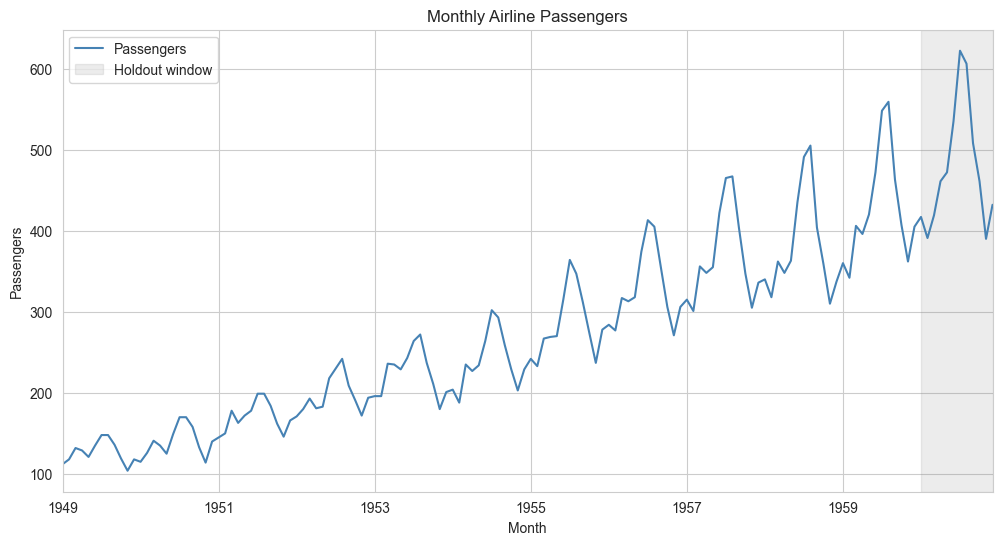

In [7]:

ax = df_wide['Passengers'].plot(color='steelblue', label='Passengers')
ax.axvspan(test_start, test_end, color='grey', alpha=0.15, label='Holdout window')
ax.set(title='Monthly Airline Passengers', xlabel='Month', ylabel='Passengers')
ax.legend()
plt.show()



## Initial Diagnostics
We replicate the PyCaret exploratory plots (ACF/PACF and seasonal decomposition) using `statsmodels`.


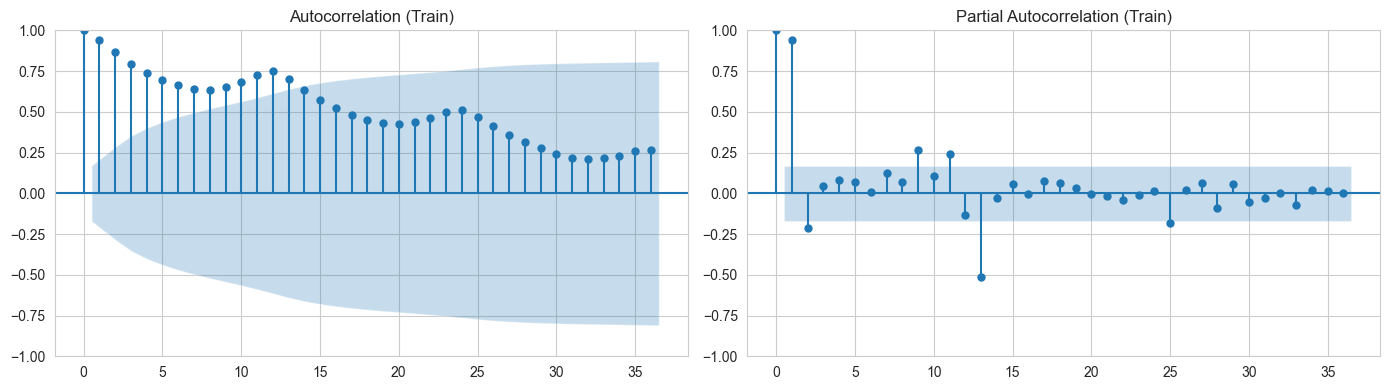

In [8]:

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(train_wide['Passengers'], lags=36, ax=axes[0])
plot_pacf(train_wide['Passengers'], lags=36, ax=axes[1], method='ywm')
axes[0].set_title('Autocorrelation (Train)')
axes[1].set_title('Partial Autocorrelation (Train)')
plt.tight_layout()
plt.show()


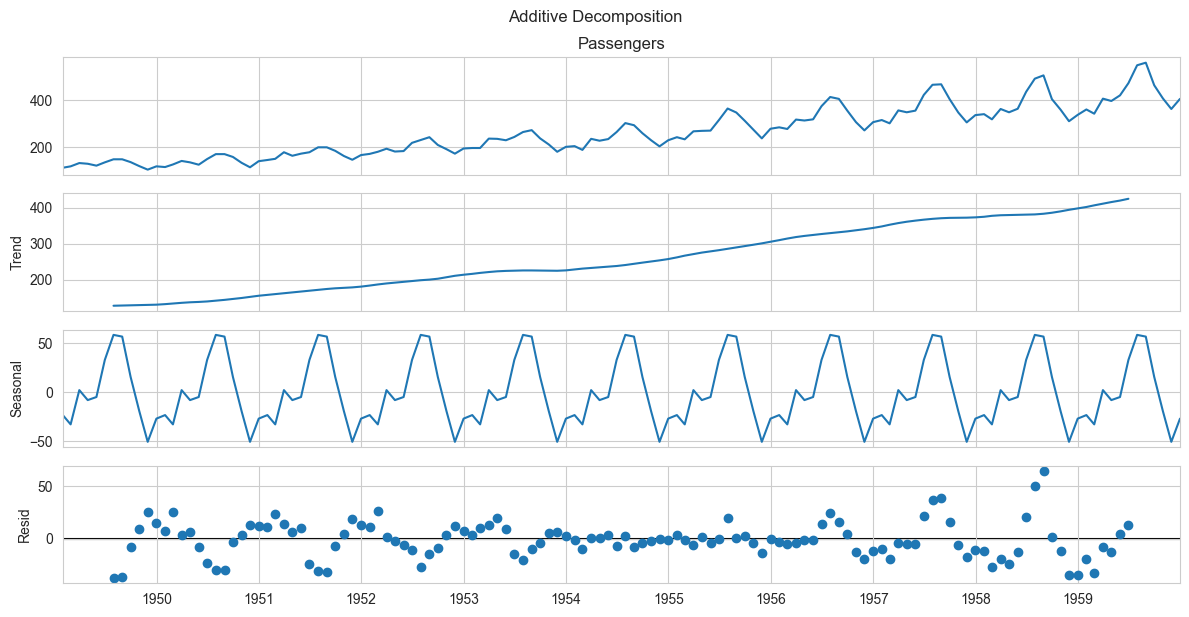

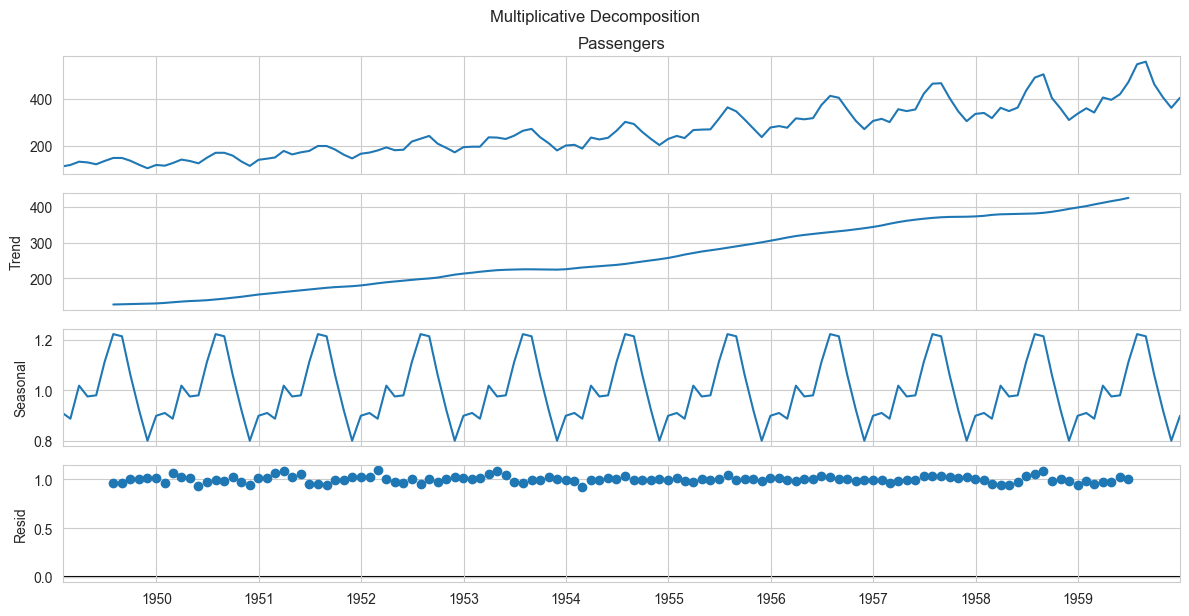

In [9]:

additive_decomp = seasonal_decompose(train_wide['Passengers'], model='additive', period=SEASON_LENGTH)
multiplicative_decomp = seasonal_decompose(train_wide['Passengers'], model='multiplicative', period=SEASON_LENGTH)

fig = additive_decomp.plot()
fig.suptitle('Additive Decomposition', y=1.02)
plt.show()

fig = multiplicative_decomp.plot()
fig.suptitle('Multiplicative Decomposition', y=1.02)
plt.show()



## Helper Utilities
StatsForecast returns forecasts in long format. We define small helpers to:
- Combine forecasts with actual holdout observations.
- Evaluate models with `utilsforecast.evaluation.evaluate`.
- Plot forecasts + residual diagnostics to mirror PyCaret's `plot_model` outputs.


In [10]:

from typing import Iterable

def evaluate_holdout(forecasts: pd.DataFrame, models: Iterable[str]) -> pd.DataFrame:
    '''Merge model forecasts with holdout observations and compute core metrics.'''
    merged = forecasts.merge(test_long, on=['unique_id', 'ds'], how='left')
    metrics = evaluate(
        df=merged,
        models=list(models),
        metrics=[
            mae,
            mape,
            rmse,
            partial(mase, seasonality=SEASON_LENGTH),
            partial(rmsse, seasonality=SEASON_LENGTH),
        ],
        train_df=train_long,
        id_col='unique_id',
        time_col='ds',
        target_col='y',
    )
    return metrics

def plot_forecast(df_actual: pd.DataFrame, forecasts: pd.DataFrame, models: Iterable[str], title: str = 'Forecast vs Actual'):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df_actual['ds'], df_actual['y'], label='Actual', color='black')
    for model in models:
        ax.plot(forecasts['ds'], forecasts[model], label=model)
    ax.set(title=title, xlabel='Month', ylabel='Passengers')
    ax.legend()
    plt.show()

def plot_residuals(fitted_values: pd.DataFrame, model: str, start_date=None):
    fv = fitted_values.dropna(subset=[model]).copy()
    if start_date is not None:
        fv = fv[fv['ds'] >= start_date]
    residuals = fv['y'] - fv[model]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(residuals, kde=True, ax=axes[0], color='firebrick')
    axes[0].set_title(f'{model} Residual Distribution')
    plot_acf(residuals, lags=24, ax=axes[1])
    axes[1].set_title(f'{model} Residual ACF')
    plt.tight_layout()
    plt.show()

    return residuals



## Exponential Smoothing Models (SES, Holt, Holt-Winters)
We mirror the PyCaret workflow by fitting three core exponential smoothing structures using StatsForecast:
- `SimpleExponentialSmoothingOptimized` (akin to SES with optimized smoothing).
- `Holt` with additive trend.
- `HoltWinters` with additive vs multiplicative error structures.

Forecasts are generated on the 12-month holdout window, while in-sample fitted values allow residual diagnostics similar to PyCaret's `plot_model(..., plot='insample')` outputs.


In [11]:

exp_models = [
    SimpleExponentialSmoothingOptimized(alias='SESOpt'),
    Holt(season_length=SEASON_LENGTH, error_type='A', alias='Holt'),
    HoltWinters(season_length=SEASON_LENGTH, error_type='A', alias='HW_Additive'),
    HoltWinters(season_length=SEASON_LENGTH, error_type='M', alias='HW_Multiplicative'),
]

sf_exp = StatsForecast(models=exp_models, freq='ME')
exp_forecasts = sf_exp.forecast(h=HOLDOUT_HORIZON, df=train_long, fitted=True)
exp_forecasts.head()


,unique_id,ds,SESOpt,Holt,HW_Additive,HW_Multiplicative
0,AirPassengers,1960-01-31,404.57431,407.222015,409.680145,412.437103
1,AirPassengers,1960-02-29,404.57431,409.448090,390.044067,409.384521
2,AirPassengers,1960-03-31,404.57431,411.674194,448.929810,473.815887
3,AirPassengers,1960-04-30,404.57431,413.900269,435.445007,454.738251
4,AirPassengers,1960-05-31,404.57431,416.126343,454.699951,454.902618


In [12]:

exp_metrics = evaluate_holdout(exp_forecasts, models=[m.alias for m in exp_models])
exp_metrics


,unique_id,metric,SESOpt,Holt,HW_Additive,HW_Multiplicative
0,AirPassengers,mae,76.283793,66.356341,23.490143,19.721153
1,AirPassengers,mape,0.143064,0.124271,0.048133,0.040468
2,AirPassengers,rmse,103.271185,92.713338,26.228497,25.719995
3,AirPassengers,mase,2.505215,2.179190,0.771433,0.647657
4,AirPassengers,rmsse,2.989185,2.683588,0.759184,0.744465


In [13]:
# creating the fitted values 
exp_fitted = sf_exp.forecast_fitted_values()
exp_fitted.head()

,unique_id,ds,y,SESOpt,Holt,HW_Additive,HW_Multiplicative
0,AirPassengers,1949-01-31,112.0,NaN,112.321053,101.031303,102.935043
1,AirPassengers,1949-02-28,118.0,112.000000,114.225983,121.179947,103.201859
2,AirPassengers,1949-03-31,132.0,117.939964,120.225952,100.400383,120.814117
3,AirPassengers,1949-04-30,129.0,131.859314,134.226334,133.717758,117.174995
4,AirPassengers,1949-05-31,121.0,129.028610,131.227509,170.780991,118.493065


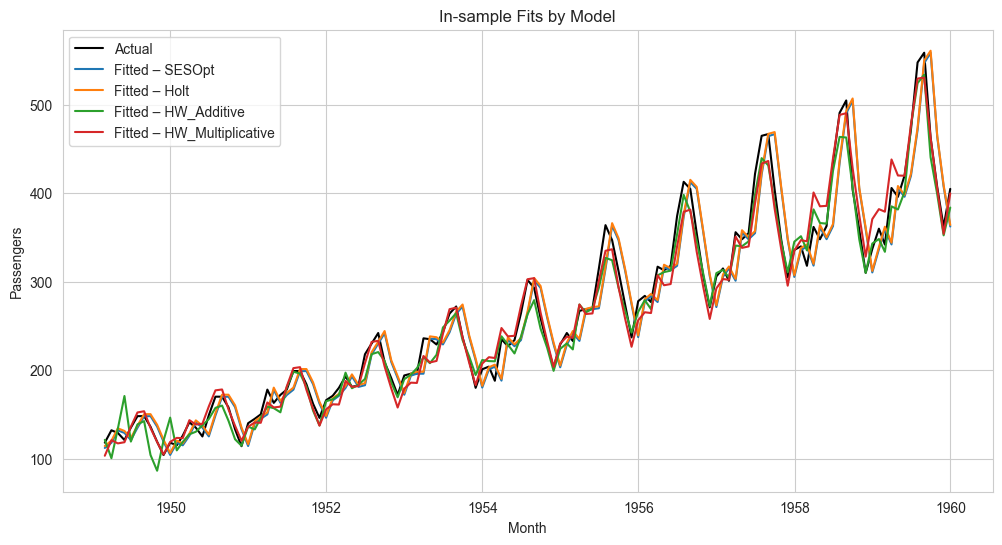

In [14]:
# plotting the fitted values 
exp_fitted = sf_exp.forecast_fitted_values()

def plot_fitted(df, models, title):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df['ds'], df['y'], color='black', label='Actual')
    for m in models:
        ax.plot(df['ds'], df[m], label=f'Fitted – {m}')
    ax.set(title=title, xlabel='Month', ylabel='Passengers')
    ax.legend()
    plt.show()

plot_fitted(
    exp_fitted.dropna(),  # drop the initial NaNs before the model warms up
    models=['SESOpt', 'Holt', 'HW_Additive', 'HW_Multiplicative'],
    title='In-sample Fits by Model'
)



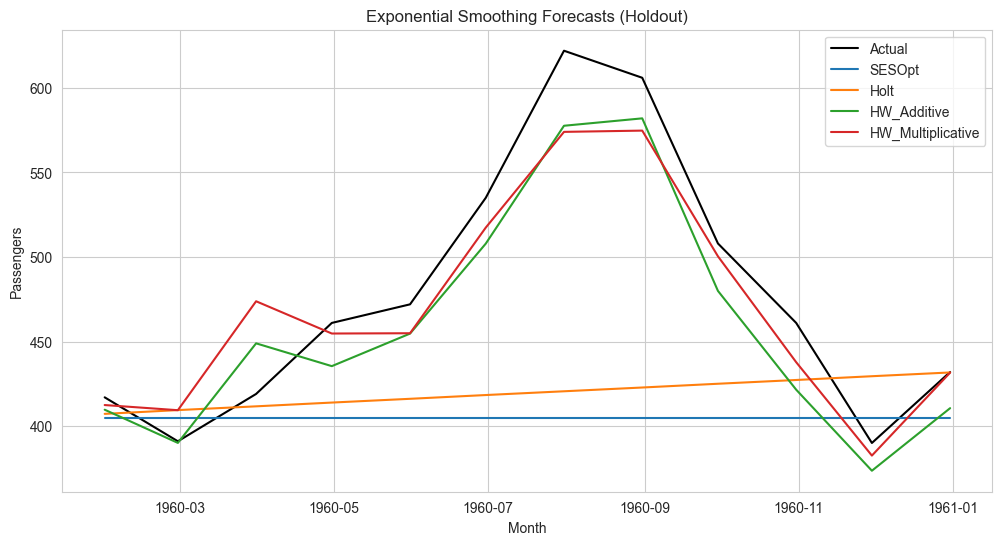

In [15]:

plot_forecast(test_long, exp_forecasts, models=['SESOpt', 'Holt', 'HW_Additive', 'HW_Multiplicative'], title='Exponential Smoothing Forecasts (Holdout)')


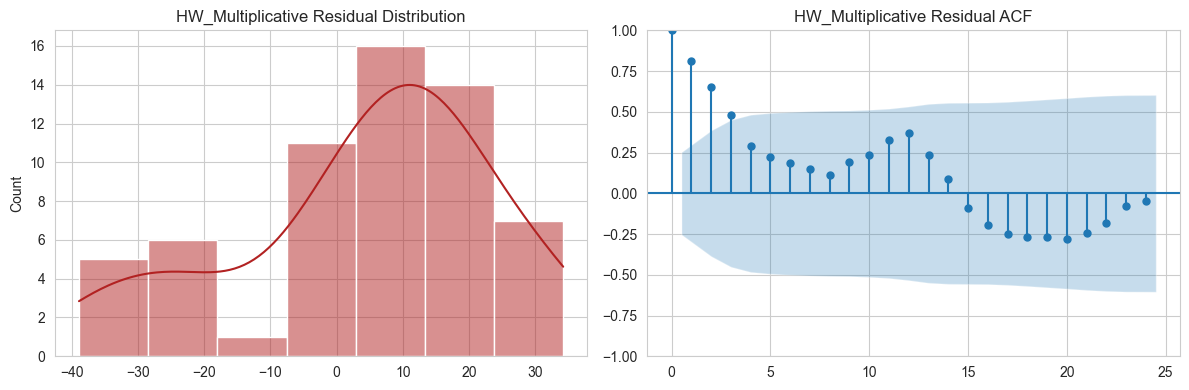

In [16]:

exp_fitted = sf_exp.forecast_fitted_values()
_ = plot_residuals(exp_fitted, model='HW_Multiplicative', start_date='1955-01-31')



## ETS Models with AutoETS
StatsForecast wraps Exponential Smoothing state-space models inside `AutoETS`. Below we fit specific configurations (ANN, AAN, MAM) alongside the automatic search (`ZZZ`), then compare them on the 12-month holdout window and inspect diagnostics.

interesting note: some model combinations like AutoETS(model='AAM') is still disallowed in StatsForecast. The library mirrors Hyndman’s state‑space rules: if you pick additive error (A) you can’t combine it with any multiplicative (M) trend or seasonal component. So ANN and AAN are fine, but AAM (additive error, additive trend, multiplicative seasonality) triggers the “Forbidden model combination” exception.

To get the multiplicative seasonal behaviour, switch to a multiplicative error instead, e.g.


In [17]:
ets_models = [
    AutoETS(model='ZZZ', season_length=SEASON_LENGTH, alias='AutoETS_ZZZ'),
    AutoETS(model='ANN', season_length=SEASON_LENGTH, alias='ETS_ANN'),
    AutoETS(model='AAN', season_length=SEASON_LENGTH, alias='ETS_AAN'),
    AutoETS(model='MAM', season_length=SEASON_LENGTH, alias='ETS_MAM')
    # Multiplicative error required when using multiplicative components,
]

baseline_models = [
    Naive(alias='Naive'),
    SeasonalNaive(season_length=SEASON_LENGTH, alias='SeasonalNaive'),
]

sf_ets = StatsForecast(models=ets_models + baseline_models, freq='ME')
ets_forecasts = sf_ets.forecast(h=HOLDOUT_HORIZON, df=train_long, fitted=True)
ets_forecasts.head()

,unique_id,ds,AutoETS_ZZZ,ETS_ANN,ETS_AAN,ETS_MAM,Naive,SeasonalNaive
0,AirPassengers,1960-01-31,406.651276,404.995697,407.222015,412.437103,405.0,360.0
1,AirPassengers,1960-02-29,401.732910,404.995697,409.448090,409.384521,405.0,342.0
2,AirPassengers,1960-03-31,456.289642,404.995697,411.674194,473.815887,405.0,406.0
3,AirPassengers,1960-04-30,440.870514,404.995697,413.900269,454.738251,405.0,396.0
4,AirPassengers,1960-05-31,440.333923,404.995697,416.126343,454.902618,405.0,420.0


In [18]:
ets_metrics = evaluate_holdout(
    ets_forecasts,
    models=[m.alias for m in ets_models + baseline_models]
)
ets_metrics


,unique_id,metric,AutoETS_ZZZ,ETS_ANN,ETS_AAN,ETS_MAM,Naive,SeasonalNaive
0,AirPassengers,mae,35.612475,76.002869,66.356341,19.721153,76.000000,47.833333
1,AirPassengers,mape,0.072068,0.142519,0.124271,0.040468,0.142513,0.099875
2,AirPassengers,rmse,40.083621,102.979508,92.713338,25.719995,102.976535,50.708316
3,AirPassengers,mase,1.169539,2.495989,2.179190,0.647657,2.495895,1.570881
4,AirPassengers,rmsse,1.160221,2.980742,2.683588,0.744465,2.980656,1.467752


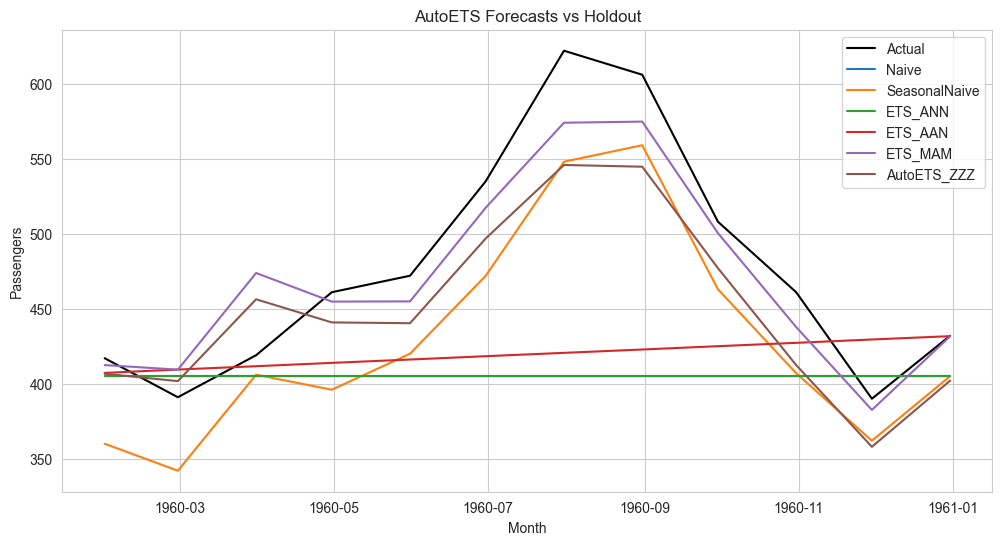

In [19]:
plot_forecast(
    test_long,
    ets_forecasts,
    models=['Naive', 'SeasonalNaive', 'ETS_ANN', 'ETS_AAN', 'ETS_MAM', 'AutoETS_ZZZ'],
    title='AutoETS Forecasts vs Holdout'
)


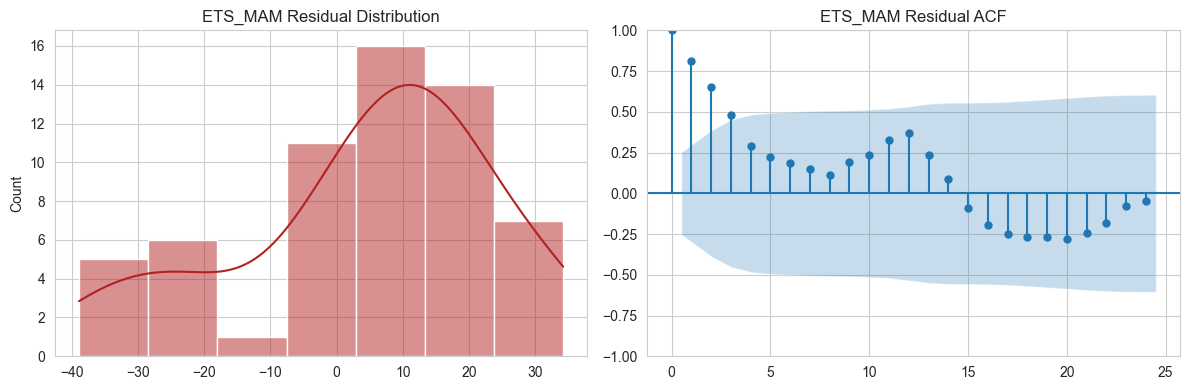

In [20]:

ets_fitted = sf_ets.forecast_fitted_values()
_ = plot_residuals(ets_fitted, model='ETS_MAM', start_date='1955-01-31')


In [21]:
# adding confidence intervals to the forecasts of an specific model
my_model = [
    AutoETS(model='ZAA', season_length=SEASON_LENGTH, alias='ETS_ZAA'),
    # ... other models if you want
]

sf_ets = StatsForecast(models=my_model, freq='ME')
ets_forecasts = sf_ets.forecast(
    df=train_long,
    h=HOLDOUT_HORIZON,
    level=[90],          # request 90% interval
    fitted=False
)

ets_forecasts.head()

,unique_id,ds,ETS_ZAA,ETS_ZAA-lo-90,ETS_ZAA-hi-90
0,AirPassengers,1960-01-31,400.209106,360.341400,440.076813
1,AirPassengers,1960-02-29,383.087616,344.925507,421.249725
2,AirPassengers,1960-03-31,439.274292,395.515015,483.033569
3,AirPassengers,1960-04-30,429.183228,386.429199,471.937286
4,AirPassengers,1960-05-31,447.211761,402.661774,491.761749


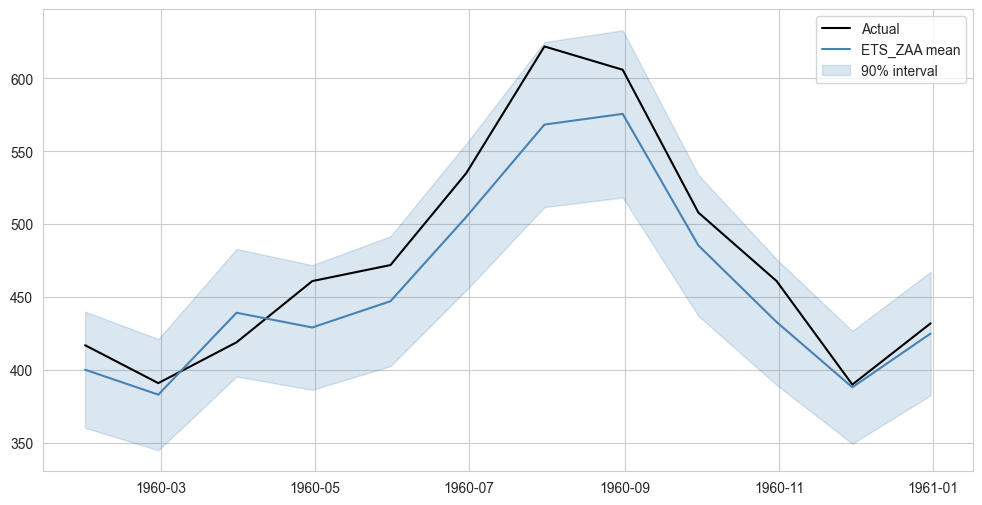

In [23]:
mam_fcst = ets_forecasts[ets_forecasts['unique_id'] == UNIQUE_ID]

plt.figure(figsize=(12, 6))
plt.plot(test_long['ds'], test_long['y'], label='Actual', color='black')
plt.plot(mam_fcst['ds'], mam_fcst['ETS_ZAA'], label='ETS_ZAA mean', color='steelblue')
plt.fill_between(
    mam_fcst['ds'],
    mam_fcst['ETS_ZAA-lo-90'],
    mam_fcst['ETS_ZAA-hi-90'],
    color='steelblue',
    alpha=0.2,
    label='90% interval'
)
plt.legend()
plt.show()


## Conformal prediction 
with Statsforecast, we can easily add conformal predictions as well. 

In [26]:
from statsforecast.utils import ConformalIntervals

conformal_cfg = ConformalIntervals(
    n_windows=3,
    h=HOLDOUT_HORIZON,
    method='conformal_distribution'
)

ets_zaa = AutoETS(
    model='ZAA',                 # automatic error, additive trend, additive seasonality
    season_length=SEASON_LENGTH,
    alias='ETS_ZAA',
    prediction_intervals=conformal_cfg
)

sf_conf = StatsForecast(models=[ets_zaa], freq='ME')

# Calibrate conformal residuals
sf_conf.cross_validation(
    df=train_long,
    h=HOLDOUT_HORIZON,
    n_windows=conformal_cfg.n_windows
)

# Forecast with conformal bands
conf_fcst = sf_conf.forecast(
    df=train_long,
    h=HOLDOUT_HORIZON,
    level=[80, 95]
)


In [27]:
conf_fcst

,unique_id,ds,ETS_ZAA,ETS_ZAA-lo-95,ETS_ZAA-lo-80,ETS_ZAA-hi-80,ETS_ZAA-hi-95
0,AirPassengers,1960-01-31,400.209106,383.778992,388.452393,411.965790,416.639191
1,AirPassengers,1960-02-29,383.087616,356.059937,362.666962,403.508270,410.115265
2,AirPassengers,1960-03-31,439.274292,406.314270,412.386169,466.162445,472.234344
3,AirPassengers,1960-04-30,429.183228,389.297791,398.265930,460.100525,469.068695
4,AirPassengers,1960-05-31,447.211761,413.856445,415.517548,478.905975,480.567108
5,AirPassengers,1960-06-30,504.983429,483.565033,484.046143,525.920715,526.401855
6,AirPassengers,1960-07-31,568.379944,531.982422,536.355103,600.404785,604.777527
7,AirPassengers,1960-08-31,575.728455,533.775940,534.075867,617.381042,617.680969
8,AirPassengers,1960-09-30,485.466675,451.424103,453.823181,517.110168,519.509277
9,AirPassengers,1960-10-31,432.893311,407.416443,409.446198,456.340454,458.370178


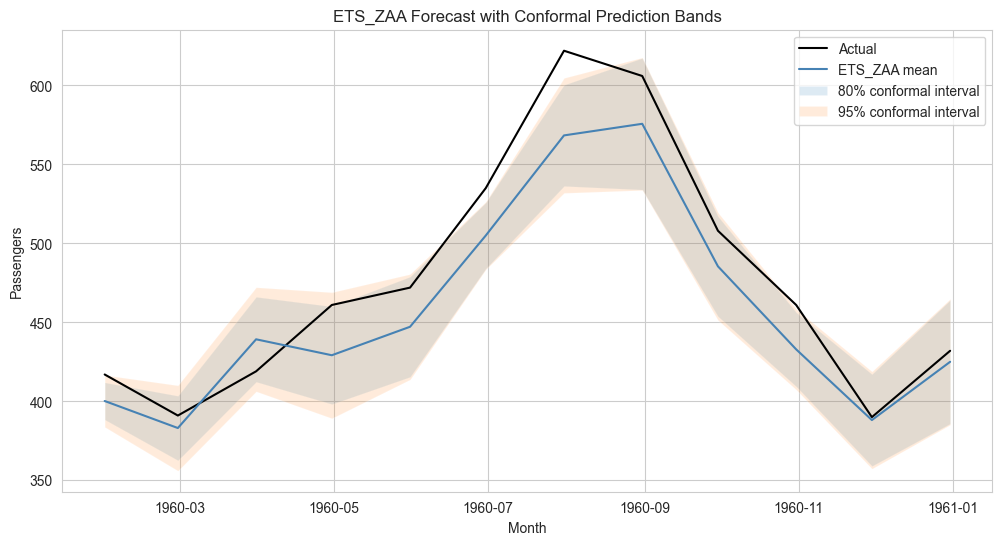

In [28]:
import matplotlib.pyplot as plt

# Filter to the series you want (the alias is now ETS_ZAA)
zaa_fcst = conf_fcst[conf_fcst['unique_id'] == UNIQUE_ID].copy()

plt.figure(figsize=(12, 6))
plt.plot(test_long['ds'], test_long['y'], label='Actual', color='black')
plt.plot(zaa_fcst['ds'], zaa_fcst['ETS_ZAA'], label='ETS_ZAA mean', color='steelblue')

for lev in [80, 95]:
    plt.fill_between(
        zaa_fcst['ds'],
        zaa_fcst[f'ETS_ZAA-lo-{lev}'],
        zaa_fcst[f'ETS_ZAA-hi-{lev}'],
        alpha=0.15,
        label=f'{lev}% conformal interval'
    )

plt.title('ETS_ZAA Forecast with Conformal Prediction Bands')
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.legend()
plt.show()
